In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from tqdm import tqdm_notebook
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
s=18
platforms = ['News', 'Blogs', 'Discussions']
theme_map = {"medical supplies": "Medical Supplies",
             "ppe": "PPE",
             "recommendations": "Guidelines",
             "restrictions": "Restrictions",
             "seasonal flu": "Seasonal Flu"
            }

__authors__ = 'HK Dambanemuya, Haomin Lin'
__version__ = 'Python3'

In [2]:
print ("Reading News...")
news = pd.read_csv('../../Data/Fusion/news.csv')
news = news[news['length']>100]
news['date'] = [datetime.strftime(date, '%Y-%m-%d') for date in tqdm_notebook(pd.to_datetime(news['date']))]

print ("Reading Blogs...")
blogs = pd.read_csv('../../Data/Fusion/blogs.csv')
blogs = blogs[blogs['length']>100]
blogs['date'] = [datetime.strftime(date, '%Y-%m-%d') for date in tqdm_notebook(pd.to_datetime(blogs['date']))]

print ("Reading Discussions...")
discussions = pd.read_csv('../../Data/Fusion/discussions.csv')
discussions = discussions[discussions['length']>100]
discussions['date'] = [datetime.strftime(date, '%Y-%m-%d') for date in tqdm_notebook(pd.to_datetime(discussions['date']))]

Reading News...



Reading Blogs...



Reading Discussions...


In [3]:
# Select countries common in all 3 data sets
country_map = Counter(set(news['country']))+Counter(set(blogs['country']))+Counter(set(discussions['country']))
common_locations = []
for k,v in tqdm_notebook(country_map.items()):
    if (v == 3) and (k==k):
        common_locations.append(k)
print("Common Countries:", len(common_locations))


Common Countries: 79


In [4]:
# Filter data by common countries
news = news[news['country'].isin(common_locations)]
blogs = blogs[blogs['country'].isin(common_locations)]
discussions = discussions[discussions['country'].isin(common_locations)]
print ("News:", len(news))
print ("Blogs:", len(blogs))
print ("Discussions:", len(discussions))

News: 2277563
Blogs: 946755
Discussions: 409091


In [5]:
dates = sorted(list(set(news['date']).union(set(blogs['date'])).union(set(discussions['date']))))[1:-1][::7]

In [6]:
platforms_sentiment = []
for platform in tqdm_notebook([news, blogs, discussions]):
    platform_themes_sentiment = []
    for theme in sorted(theme_map.keys(),reverse=True):
        theme_weekly_sentiment = []
        for i in range(len(dates)-1):
            week_sentiment = platform[(platform['theme'].str.contains(theme)) & 
                                      (platform['date']>dates[i]) &
                                      (platform['date']<=dates[i+1])]['sentiment'].dropna().mean()
            theme_weekly_sentiment.append(week_sentiment)
        platform_themes_sentiment.append(theme_weekly_sentiment)
    platforms_sentiment.append(platform_themes_sentiment)

In [7]:
platforms_volume = []
for platform in tqdm_notebook([news, blogs, discussions]):
    platform_themes_volume = []
    for theme in sorted(theme_map.keys(),reverse=True):
        theme_weekly_volume  = []
        for i in range(len(dates)-1):
            week_volume  = len(platform[(platform['theme'].str.contains(theme)) & 
                                    (platform['date']>dates[i]) &
                                    ((platform['date']<=dates[i+1]))])
            theme_weekly_volume.append(week_volume)
        platform_themes_volume.append(theme_weekly_volume)
    platforms_volume.append(platform_themes_volume)

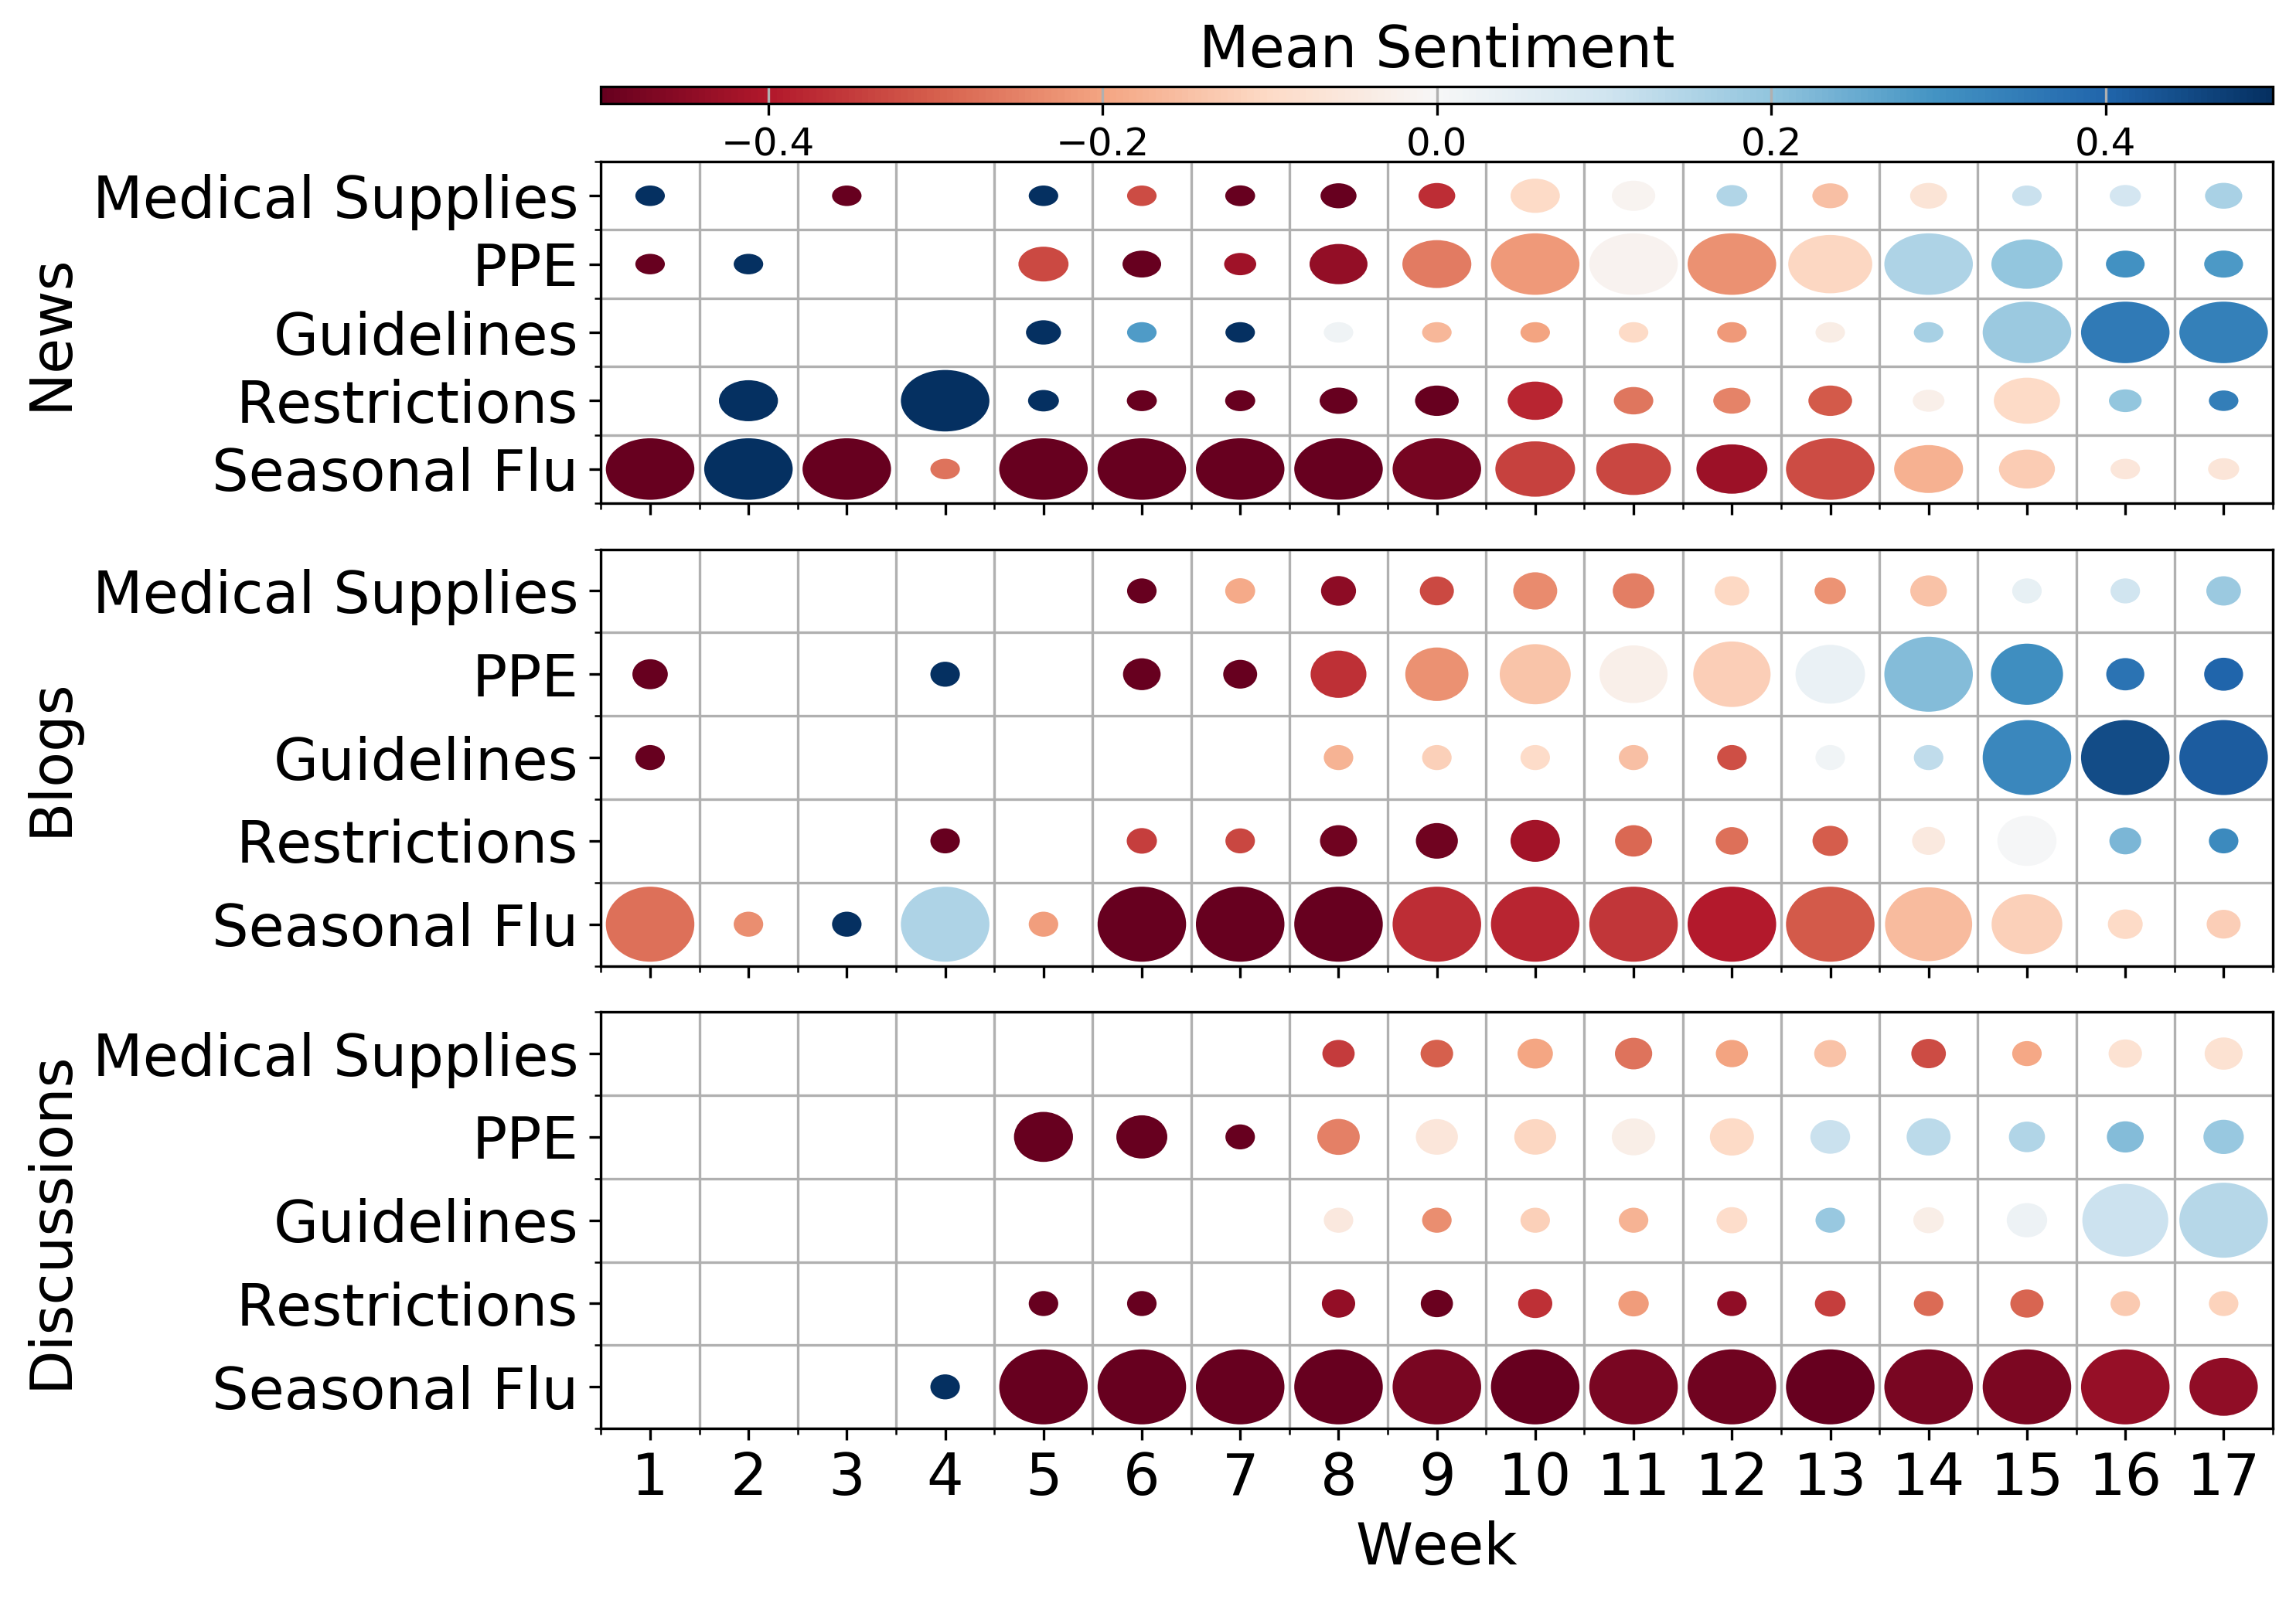

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(10,7), sharex=True, sharey=True, dpi=300)

N, M, = 5, 17

xlabels = np.arange(1,18,1)
ylabels = list(theme_map.values())[::-1]
x, y = np.meshgrid(np.arange(M), np.arange(N))

scaler = MinMaxScaler(feature_range=(.03,.45))

for idx, volume, sentiment in (zip(np.arange(0,3), platforms_volume, platforms_sentiment)):
    volume = np.array(volume)
    min_value = volume.min()
    volume = volume.astype('float')
    volume[volume == 0] = np.nan
    
    scaler = MinMaxScaler(feature_range=(min_value+.15,.45))
    
    R = scaler.fit_transform(volume)
    sentiment = np.array(sentiment)
    
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=sentiment.flatten(), cmap="RdBu")
    
    ax[idx].add_collection(col)
    ax[idx].set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax[idx].set_xticks(np.arange(M+1)-0.5, minor=True)
    ax[idx].set_yticks(np.arange(N+1)-0.5, minor=True)
    ax[idx].set_xticklabels(xlabels, fontsize=s)
    ax[idx].set_yticklabels(ylabels, fontsize=s)
    ax[idx].grid(which='minor')
    ax[idx].set_ylabel(platforms[idx], fontsize=s)
    col.set_clim(-.5,.5)
    
    if idx == 0:
        col.set_clim(-.5,.5)
        divider = make_axes_locatable(ax[idx])
        cax = divider.append_axes('top', size="5%", pad=0.25)
        cbar = fig.colorbar(col, ax=ax[idx], cax=cax, orientation='horizontal') 
        cbar.ax.tick_params(labelsize=s-6)
    if idx==2:
        ax[idx].set_xlabel('Week', fontsize=s)

plt.title('Mean Sentiment', fontsize=s)
plt.grid()
plt.tight_layout()
plt.show()

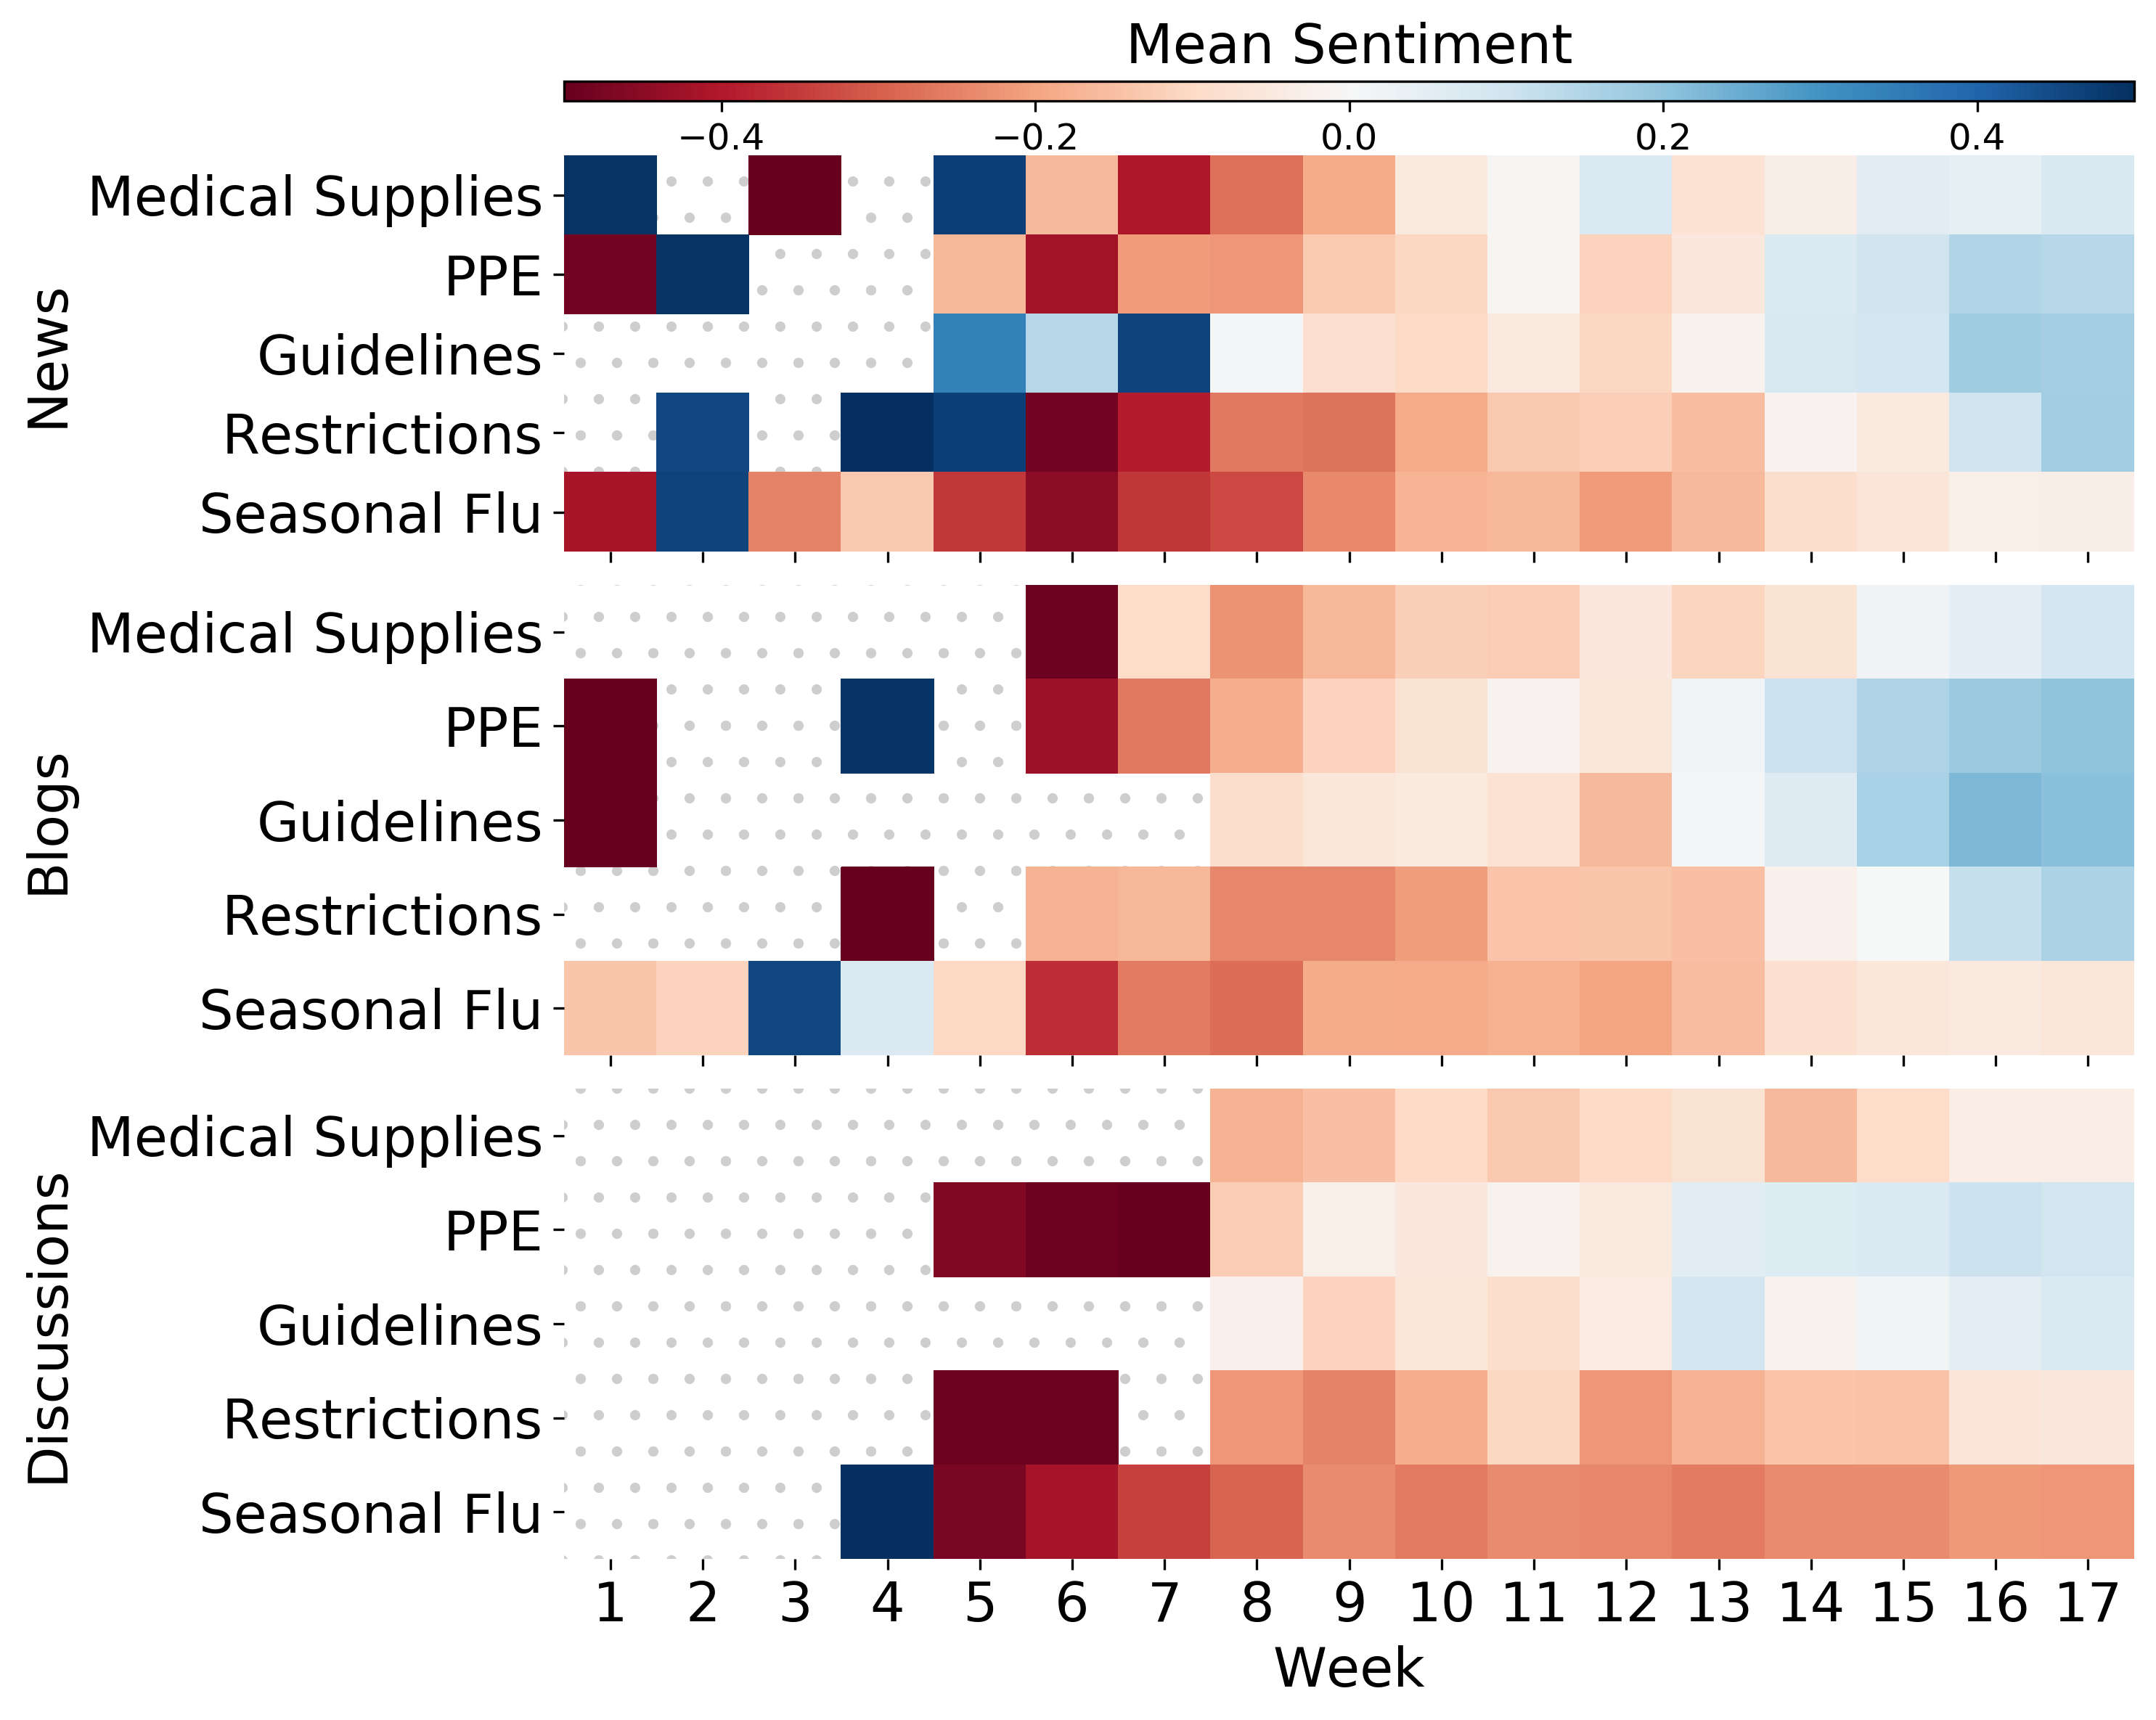

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10,8), sharex=True, sharey=True, dpi=300)

xlabels = np.arange(1,18,1)
# ylabels = sorted(theme_map.values(), reverse=True)

for idx, platform in enumerate(platforms_sentiment):
    sns.heatmap(platform[::-1], ax=ax[idx], cmap='RdBu', vmin=-1, vmax=1, alpha=1, cbar=False)
    ax[idx].set_xticklabels(xlabels, fontsize=s)
    ax[idx].set_yticklabels(ylabels[::-1], fontsize=s, rotation=360)
    ax[idx].set_ylabel(platforms[idx], fontsize=s)
    ax[idx].patch.set(hatch='.', edgecolor='#cecece')
    
    if idx == 0:
        divider = make_axes_locatable(ax[idx])
        cax = divider.append_axes('top', size="5%", pad=0.25)
        cbar = fig.colorbar(col, ax=ax[idx], cax=cax, orientation='horizontal') 
        cbar.ax.tick_params(labelsize=s-6)
        
    if idx==2:
        ax[idx].set_xlabel('Week', fontsize=s)
        
plt.title('Mean Sentiment', fontsize=s)
plt.tight_layout()
plt.show()